# Topic modeling without Theta distribution

Based on unpublished (yet) research by Ilya Irhin, Victor Bulatov, Konstantin Vorontsov

One of the interpretations of topic modeling is this:

\begin{equation}
L(\Phi, \Theta) + R(\Phi, \Theta) \to \max_{\Phi, \Theta},
\end{equation}

Once the inference is directly formulated as an optimization problem, one can ask: is it possible to reduce the number f inferred parameters? 

In the practice, word-topic matrix $(\Phi)$ has a larger importance than document-topic matrix $(\Theta)$; so we can replace the original optimization problem with a different one:

\begin{equation}
L(\Phi, f(\Phi) ) + R(\Phi, f(\Phi) ) \to \max_{\Phi},
\end{equation}

Some math later, it turns out that the "formally correct" optimization algorithm for this problem is different from conventional EM algorithm, and has some surprising advantages. Technically speaking, these formulas require a different iteration process (which is implemented here: https://github.com/ilirhin/python_artm), but the formulas look similar enough to a custom $\Phi$ regularizer (if one sets `num_document_passes=1` in BigARTM)

This notebook serves as a proof-of-concept for this idea.


In [2]:
from collections import Counter

import numpy as np
import pandas as pd
from numpy import random
from matplotlib import pyplot as plt
from numba import jit
import scipy.sparse

import artm

from topicnet.cooking_machine.dataset import Dataset

from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.models.base_regularizer import BaseRegularizer
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorRegularizer

from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [1]:
from topicnet.cooking_machine.models.thetaless_regularizer import ThetalessRegularizer

# TopicPriorRegularizer are used here to make Phi sparse
# usually, we use an artm.SmoothSparsePhiRegularizer for this, but then it makes the performance comparision "unfair"

from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorRegularizer


# the definition of Thetaless regularizer



## Preparing the dataset

In [3]:
import ast


In [4]:
def csv2sparse_matrix(train_df, token_to_id=None, ignore_unknown_tokens=False):
    if token_to_id is None:
        token_to_id = dict()
    train_row, train_col, train_data = [], [], []
    for row_num, r in enumerate(train_df.iterrows()):
        bag_of_words = Counter()
        for token, _ in ast.literal_eval(r[1].tokenized):
            token_id = token_to_id.get(token)
            if token_id is None:
                if ignore_unknown_tokens:
                    continue
                token_id = len(token_to_id)
                token_to_id[token] = token_id
            bag_of_words[token_id] += 1

        for token_id, count in bag_of_words.items():
            train_row.append(row_num)
            train_col.append(token_id)
            train_data.append(count)

    train_n_dw_matrix = scipy.sparse.csr_matrix(
        (train_data, (train_row, train_col)), 
        shape=(len(train_df), len(token_to_id))
    )
    return train_n_dw_matrix, token_to_id


train_df = pd.read_csv('/data_mil/datasets/20_News_dataset/train_preprocessed.csv')
train_n_dw_matrix, token_to_id = csv2sparse_matrix(train_df)

In [5]:

test_df = pd.read_csv('/data_mil/datasets/20_News_dataset/train_preprocessed.csv')
test_n_dw_matrix, _ = csv2sparse_matrix(test_df, dict(token_to_id), True)

vocabulary = {
    token_id: token
    for token, token_id in token_to_id.items()
}

In [6]:
train_batch_vectorizer = artm.BatchVectorizer(
    data_format='bow_n_wd', 
    n_wd=train_n_dw_matrix.T, 
    vocabulary=vocabulary, 
    batch_size=100000
)

In [7]:
test_batch_vectorizer = artm.BatchVectorizer(
    data_format='bow_n_wd', 
    n_wd=test_n_dw_matrix.T, 
    vocabulary=vocabulary, 
    batch_size=100000
)

### Обучение модели

In [8]:
def create_model():
    model = artm.ARTM(num_topics=30, num_document_passes=1)
    model.scores.add(artm.scores.PerplexityScore(name='perplexity'))
    model.scores.add(artm.scores.PerplexityScore(
        name='test_perplexity', 
        dictionary=test_batch_vectorizer.dictionary
    ))
    model.scores.add(artm.scores.SparsityPhiScore(name='sparsity'))
    model.scores.add(artm.scores.TopicKernelScore(name='kernel'))
    model.initialize(train_batch_vectorizer.dictionary)
    return model


def fit(model):
    model._fit(
        dataset_trainable=train_batch_vectorizer, 
        num_iterations=50
    )

In [9]:
thetaless_reg = ThetalessRegularizer(
    name='thetaless', 
    tau=1, 
    n_dw_matrix=train_n_dw_matrix
)

sparse_reg = TopicPriorRegularizer(
    name='sparse_reg', 
    tau=-0.5, 
    beta=1,
    num_topics=30
)

## Top-token coherence (co-occurrences are calculated using the same corpus)

In [10]:
import numpy as np


def calc_doc_occurrences(n_dw_matrix):
    """
    :param n_dw_matrix: sparse document-word matrix, shape is D x W
    :return: sparse matrix of co-occurrences

    doc_occurrences[w1, w2] = the number of the documents
    where there are w1 and w2
    """
    matrix = (scipy.sparse.csc_matrix(n_dw_matrix) > 0).astype(int)
    co_occurrences = matrix.T * matrix
    return co_occurrences.diagonal(), co_occurrences


def create_pmi_top_function(
    doc_occurrences, doc_co_occurrences,
    documents_number, top_sizes,
    co_occurrences_smooth=1.
):
    """
    :param doc_occurrences: array of doc occurrences of words
    :param doc_co_occurrences: sparse matrix of doc co-occurrences of words
    :param documents_number: number of the documents
    :param top_sizes: list of top values to calculate top-pmi for
    :param co_occurrences_smooth: constant to smooth co-occurrences in log
    :return: function which takes phi and theta and returns
    pair of two arrays: pmi-s of the tops and ppmi-s of the tops

    pmi[i] - pmi(top of size top_sizes[i])
    ppmi[i] - ppmi(top of size top_sizes[i])

    pmi(words) = sum_{u in words, v in words, u != v}
    log(
        (doc_co_occurrences[u, v] * documents_number + co_occurrences_smooth)
        / doc_occurrences[u] / doc_occurrences[v]
    )

    ppmi(words) = sum_{u in words, v in words, u != v}
    max(log(
        (doc_co_occurrences[u, v] * documents_number + co_occurrences_smooth)
        / doc_occurrences[u] / doc_occurrences[v]
    ), 0)

    """
    def func(phi):
        T, W = phi.shape
        max_top_size = max(top_sizes)
        pmi, ppmi = np.zeros(max_top_size), np.zeros(max_top_size)
        tops = np.argpartition(phi, -max_top_size, axis=1)[:, -max_top_size:]
        for t in range(T):
            top = sorted(tops[t], key=lambda w: - phi[t, w])
            co_occurrences = doc_co_occurrences[top, :][:, top].todense()
            occurrences = doc_occurrences[top]
            values = np.log(
                (co_occurrences * documents_number + co_occurrences_smooth)
                / occurrences[:, np.newaxis]
                / occurrences[np.newaxis, :]
            )
            diag = np.diag_indices(len(values))
            values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            pmi += np.array(
               values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            ).ravel()
            values[values < 0.] = 0.
            ppmi += np.array(
               values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            ).ravel()
        sizes = np.arange(2, max_top_size + 1)
        pmi[1:] /= (T * sizes * (sizes - 1))
        ppmi[1:] /= (T * sizes * (sizes - 1))
        indices = np.array(top_sizes) - 1
        return pmi[indices], ppmi[indices]

    return func


In [11]:
occurences, co_occurences = calc_doc_occurrences(train_n_dw_matrix)
calc_pmi = create_pmi_top_function(
    occurences, co_occurences,
    test_n_dw_matrix.shape[0], [20],
    co_occurrences_smooth=1.
)

In [13]:
from topicnet.cooking_machine.models import BaseScore as BaseTopicNetScore, TopicModel


class TopTokenCoherence(BaseTopicNetScore):
    def __init__(self, func):
        super().__init__()

        self.calc_pmi = func

    def call(self, model: TopicModel):
        values = self.calc_pmi(model.get_phi_dense()[0].T)

        return values[1]


In [14]:
plsa_model = TopicModel(
    artm_model=create_model(), 
    model_id='plsa_model',
    custom_scores={"coherence_ppmi": TopTokenCoherence(calc_pmi)}
)

%time fit(plsa_model)

CPU times: user 2min, sys: 17 s, total: 2min 17s
Wall time: 1min 42s


In [15]:
thetaless_model = TopicModel(
    artm_model=create_model(), 
    model_id='thetaless_model',
    custom_regularizers={
        thetaless_reg.name: thetaless_reg
    },
    custom_scores={"coherence_ppmi": TopTokenCoherence(calc_pmi)}
)

%time fit(thetaless_model)

CPU times: user 9min 50s, sys: 1min 1s, total: 10min 52s
Wall time: 2min 47s


In [16]:
sparse_model = TopicModel(
    artm_model=create_model(), 
    model_id='sparse_model',
    custom_regularizers={
        sparse_reg.name: sparse_reg
    },
    custom_scores={"coherence_ppmi": TopTokenCoherence(calc_pmi)}
)

%time fit(sparse_model)

CPU times: user 3min 51s, sys: 1min 15s, total: 5min 6s
Wall time: 2min 33s


In [17]:
sparse_thetaless_model = TopicModel(
    artm_model=create_model(), 
    model_id='sparse_thetaless_model',
    custom_regularizers={
        sparse_reg.name: sparse_reg,
        thetaless_reg.name: thetaless_reg
    },
    custom_scores={"coherence_ppmi": TopTokenCoherence(calc_pmi)}
)

%time fit(sparse_thetaless_model)

CPU times: user 10min 42s, sys: 1min 56s, total: 12min 38s
Wall time: 2min 47s


## Quality Visualizing

In [45]:
def plot_metric(view_name, value_name, title_name):
    plt.figure(figsize=(14,8))

    plt.subplot(2,2,1)
    values = np.array(getattr(thetaless_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_thetaless = values[-1]

    plt.title(f'{title_name} with Thetaless regularizer')
    plt.plot(values[1:])

    plt.subplot(2,2,2)
    values = np.array(getattr(plsa_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_plsa = values[-1]
    
    plt.title(f'{title_name} without any regularization')
    plt.plot(values[1:])
    
    plt.subplot(2,2,3)
    values = np.array(getattr(sparse_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_sparse = values[-1]

    plt.title(f'{title_name} with sparsity regularizer')
    plt.plot(values[1:])
    
    plt.subplot(2,2,4)
    values = np.array(getattr(sparse_thetaless_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_sparse_thetaless = values[-1]

    plt.title(f'{title_name} with both regularizers')
    plt.plot(values[1:])
    
    
    print(
        f'Last values:\n\t'
        f'thetaless – {last_thetaless}\n\t'
        f'plsa – {last_plsa}\n\t'
        f'sparse – {last_sparse}\n\t'
        f'sparse_thetaless – {last_sparse_thetaless}\n\t' 
    )
    plt.show()

Last values:
	thetaless – 1227.15234375
	plsa – 1314.651123046875
	sparse – 957.7000732421875
	sparse_thetaless – 895.8453979492188
	


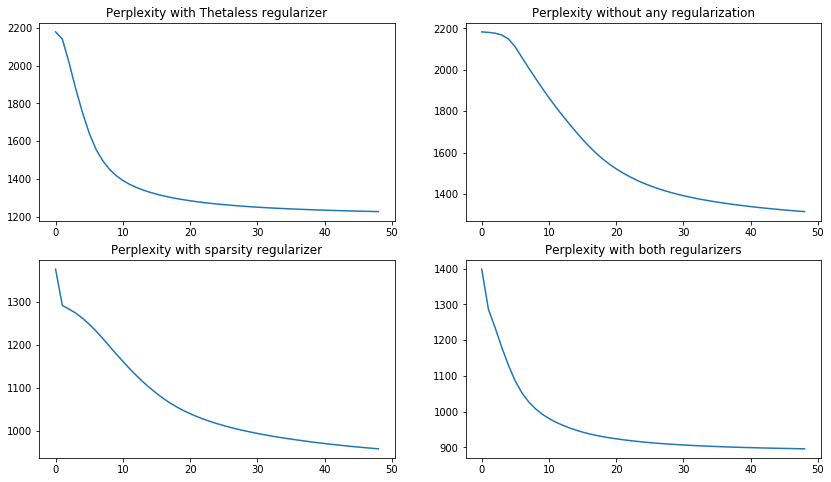

In [47]:
plot_metric(view_name='perplexity', value_name='value', title_name='Perplexity')

Last values:
	thetaless – 1227.15234375
	plsa – 1314.651123046875
	sparse – 1528.09033203125
	sparse_thetaless – 1408.190185546875
	


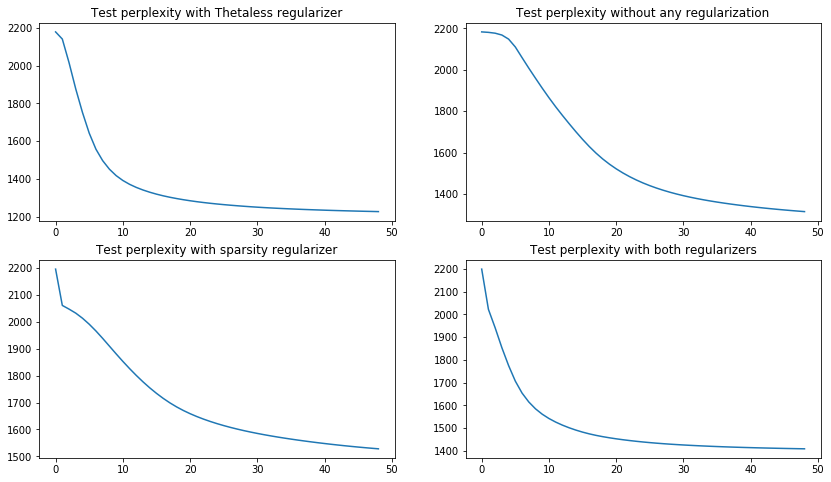

In [48]:
plot_metric(view_name='test_perplexity', value_name='value', title_name='Test perplexity')

Last values:
	thetaless – 0.9200233817100525
	plsa – 0.7717972993850708
	sparse – 0.9903578758239746
	sparse_thetaless – 0.9920385479927063
	


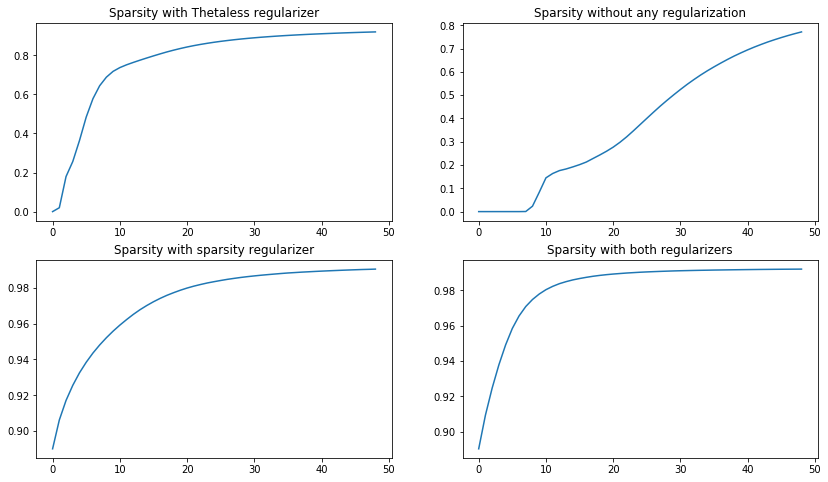

In [49]:
plot_metric(view_name='sparsity', value_name='value', title_name='Sparsity')

Last values:
	thetaless – 0.7567857503890991
	plsa – 0.6893280148506165
	sparse – 0.8266897797584534
	sparse_thetaless – 0.8727331757545471
	


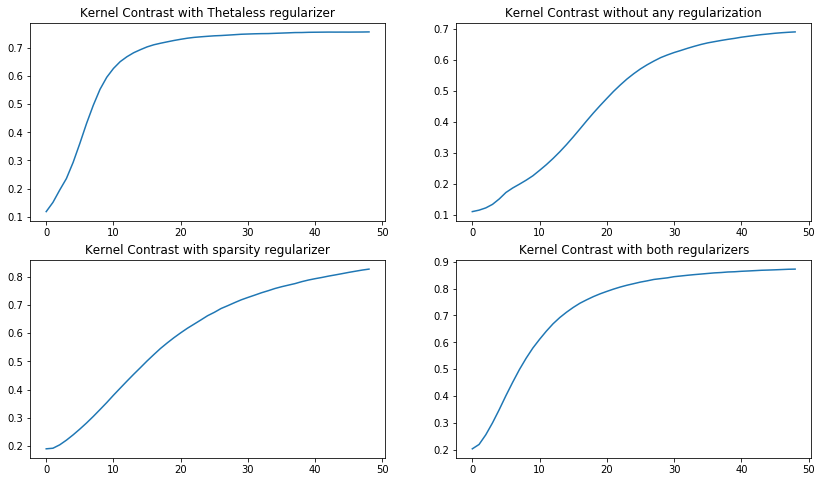

In [50]:
plot_metric(view_name='kernel', value_name='average_contrast', title_name='Kernel Contrast')

Last values:
	thetaless – 0.9363216161727905
	plsa – 0.7150622010231018
	sparse – 0.7518076300621033
	sparse_thetaless – 0.9405104517936707
	


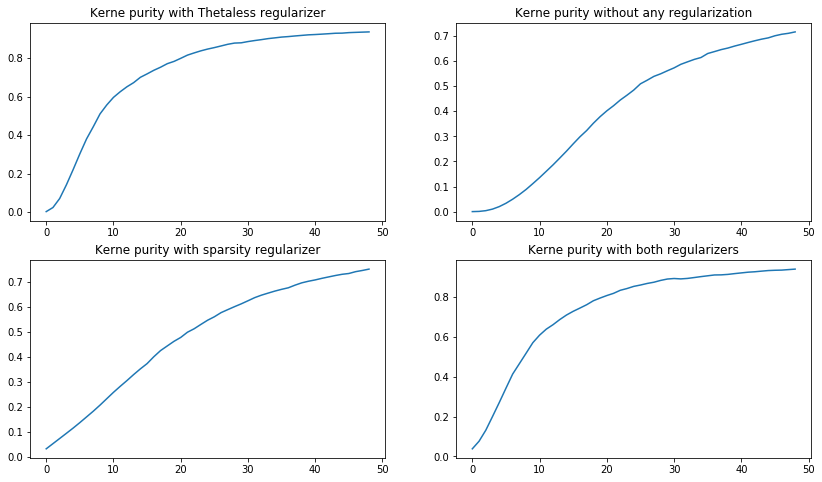

In [51]:
plot_metric(view_name='kernel', value_name='average_purity', title_name='Kerne purity')

Last values:
	thetaless – 3574.2333984375
	plsa – 3774.466552734375
	sparse – 623.433349609375
	sparse_thetaless – 621.7000122070312
	


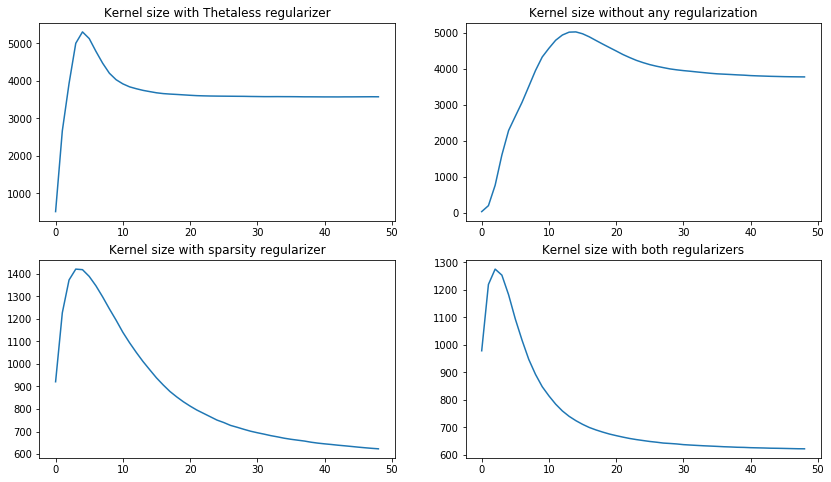

In [52]:
plot_metric(view_name='kernel', value_name='average_size', title_name='Kernel size')

Last values:
	thetaless – 1.2295665407796712
	plsa – 0.7130331816199633
	sparse – 0.6366304865617266
	sparse_thetaless – 1.0301379151242755
	


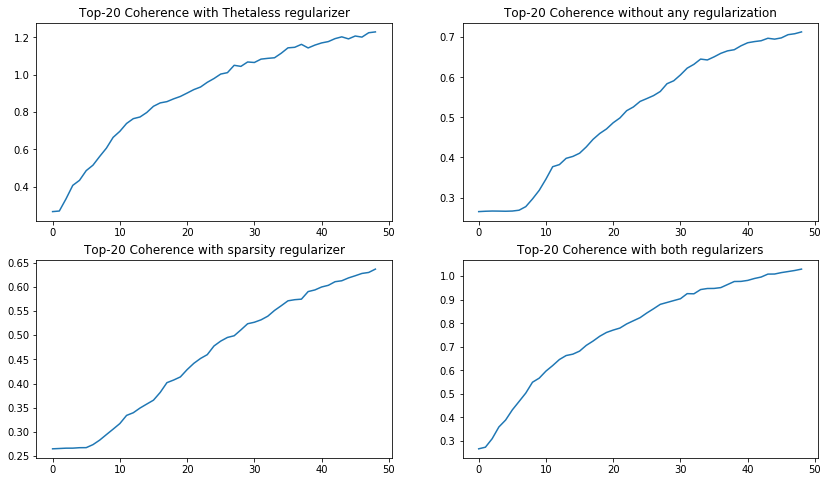

In [53]:
plot_metric(view_name='coherence_ppmi', value_name='value', title_name='Top-20 Coherence')

## Coherence evaluation on an external corpus (with Palmetto)

Unfortunately, the service isn't available right now

In [27]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
import requests


def eval_top_words(name, model, num_top_tokens=10):
    ttv = TopTokensViewer(model, method='blei', num_top_tokens=num_top_tokens)
    output = ttv.view()
    S = "http://palmetto.aksw.org/palmetto-webapp/service/{}?words=".format("umass")
    topic_score = []
    for key, modalities in output.items():
        if 'topic' in key:
            words = list(output[key]['@default_class'].keys())
            print(S + "%20".join(words))
            result = requests.get(S + "%20".join(words)).text
            topic_score += [float(result)]
    print(round(np.mean(topic_score), 2), round(np.median(topic_score), 2))

In [ ]:
# eval_top_words('thetaless', thetaless_model)

In [ ]:
# eval_top_words('plsa', plsa_model)

In [ ]:
# eval_top_words('sparse', sparse_model)

In [ ]:
# eval_top_words('sparse_thetaless', sparse_thetaless_model)

## Let's look at topics

In [28]:
def print_top_words(name, model, num_top_tokens=10):
    ttv = TopTokensViewer(model, method='blei', num_top_tokens=num_top_tokens)
    output = ttv.view()
    for key, modalities in output.items():
        if 'topic' in key:
            print(', '.join(output[key]['@default_class'].keys()))
            print()

In [29]:
print_top_words('thetaless', thetaless_model)

this, have, has, any, would, know, does, been, anyone, problem

key, system, information, public, chip, number, data, encryption, message, access

my, me, am, car, up, .., ...., :-), buy, bike

they, there, what, no, all, them, people, because, here, even

god, who, jesus, life, his, man, .", bible, christian, church

10, 00, 15, 12, 25, game, 11, team, 20, 14

of, are, ..., more, than, many, these, course, different, article

is, as, an, of, not, such, the, however, be, example

space, research, center, nasa, earth, 1993, launch, data, science, dr

or, for, use, also, can, please, need, thanks, etc, mail

it, but, so, one, think, could, only, why, good, really

the, of, by, one, must, )., book, current, subject, should

windows, drive, software, card, dos, system, disk, bit, pc, scsi

to, be, will, the, able, order, make, time, next, of

were, of, their, world, ,", armenian, by, war, armenians, turkish

graphics, ftp, edu, contact, available, runs, ->, fax, 800, pub

for, new, best, e

In [30]:
print_top_words('plsa', plsa_model)

this, have, the, any, is, to, does, not, know, anyone

is, key, of, and, the, system, information, are, public, chip

to, me, my, or, the, on, if, have, in, would

what, that, of, the, there, not, just, they, no, but

he, we, god, his, that, and, us, our, him, who

00, 10, game, 15, team, 25, 12, 11, 20, 13

of, ..., that, to, are, is, and, with, not, the

is, as, the, that, of, not, to, be, an, and

of, and, space, for, 1993, research, center, in, national, by

for, to, can, or, and, if, get, use, please, also

it, but, have, so, that, think, the, to, really, why

the, of, in, is, are, be, to, one, )., by

with, windows, drive, system, card, dos, software, bit, disk, scsi

to, is, the, on, in, this, of, with, it, can

of, the, in, and, were, by, their, armenian, war, armenians

from, available, on, list, ftp, and, mail, edu, )., version

for, and, new, good, very, with, all, best, old, price

it, is, the, in, be, too, of, an, to, are

the, and, at, into, first, in, two, on, second, ba

In [31]:
print_top_words('sparse', sparse_model)

this, any, have, to, the, does, is, anyone, not, problem

is, the, are, key, of, used, as, and, will, public

to, or, the, have, if, on, my, for, be, in

that, what, the, of, but, just, no, it, something, here

we, that, me, there, know, our, they, what, us, so

10, 00, 20, 15, 12, 25, 11, game, 14, 16

that, is, of, are, to, not, you, this, the, and

the, is, as, to, of, that, be, an, not, or

and, of, for, space, on, the, data, high, in, research

for, to, use, and, or, please, can, on, mail, also

it, have, but, so, think, that, to, really, not, the

the, not, of, is, god, that, jesus, be, must, as

with, windows, thanks, drive, software, system, card, using, version, bit

to, is, the, get, can, if, it, in, this, of

of, the, in, and, their, by, were, people, against, armenian

),, )., net, list, 80, contact, 22, box, runs, 60

for, and, new, good, very, )., or, have, work, all

is, it, the, too, an, in, be, or, are, to

the, and, first, into, in, at, back, second, with, to

that, t

In [32]:
print_top_words('sparse_thetaless', sparse_thetaless_model)

this, have, any, has, know, does, anyone, work, problem, would

key, number, information, public, group, chip, news, message, encryption, posting

my, me, like, up, am, get, could, want, on, someone

there, what, no, don, they, some, even, see, why, here

we, he, who, his, people, us, our, all, him, say

10, 00, 20, 15, 12, 25, 11, game, 14, 16

are, of, more, ..., than, many, only, case, different, course

is, as, the, not, such, of, however, or, example, makes

space, 1993, university, high, .,, national, research, center, science, of

use, on, system, or, please, thanks, can, etc, mail, hard

it, but, so, good, one, only, really, take, doesn, thing

god, of, the, must, "., jesus, one, not, person, word

windows, drive, software, card, dos, version, image, bit, disk, pc

to, the, get, on, order, way, able, when, then, time

their, were, world, against, of, ,", armenian, during, .", children

->, 100, runs, 800, 200, ----, 90, 300, steve, 500

for, and, )., new, ),, all, best, each, b

## Last coherence values (using different number of top tokens)

The plots above show how the coherence (PPMI) of top 20 tokens evolves. In addition, we can look at the last PMI and PPMI values using different sizes of top-token list (5, 10, 20, 50, 100 words)

In [33]:
occurences, co_occurences = calc_doc_occurrences(train_n_dw_matrix)
calc_pmi = create_pmi_top_function(
    occurences, co_occurences,
    test_n_dw_matrix.shape[0], [5, 10, 20, 50, 100],
    co_occurrences_smooth=1.
)

In [34]:
calc_pmi(plsa_model.get_phi_dense()[0].T)

(array([0.39794082, 0.5118048 , 0.67965463, 0.88237313, 1.04378611]),
 array([0.42403162, 0.5602503 , 0.71303318, 0.93598612, 1.11396004]))

In [35]:
calc_pmi(thetaless_model.get_phi_dense()[0].T)

(array([0.91811772, 1.01885883, 1.20539864, 1.29182469, 1.36843634]),
 array([0.91811772, 1.05672401, 1.22956654, 1.38632289, 1.55204473]))

In [36]:
calc_pmi(sparse_model.get_phi_dense()[0].T)

(array([0.38628136, 0.48798776, 0.63637099, 0.84816317, 1.00993652]),
 array([0.38628136, 0.48798776, 0.63663049, 0.86840002, 1.06419641]))

In [37]:
calc_pmi(sparse_thetaless_model.get_phi_dense()[0].T)

(array([0.73225952, 0.86980454, 1.01066112, 1.1870601 , 1.11520662]),
 array([0.73225952, 0.87038446, 1.03023163, 1.25691501, 1.40597935]))

Also, let's take a look at train + test together, instead of relying on train only:

In [38]:
matrix = scipy.sparse.vstack((train_n_dw_matrix, test_n_dw_matrix))
occurences, co_occurences = calc_doc_occurrences(matrix)
calc_pmi = create_pmi_top_function(
    occurences, co_occurences,
    matrix.shape[0], [5, 10, 20, 50, 100],
    co_occurrences_smooth=1.
)

In [39]:
calc_pmi(plsa_model.get_phi_dense()[0].T)

(array([0.39331874, 0.50256166, 0.6726003 , 0.86943263, 1.02683013]),
 array([0.42403052, 0.56024917, 0.71303195, 0.93598439, 1.11395708]))

In [40]:
calc_pmi(thetaless_model.get_phi_dense()[0].T)

(array([0.91811657, 1.01064248, 1.20028921, 1.27103585, 1.32921158]),
 array([0.91811657, 1.05672276, 1.22956457, 1.38631923, 1.55203787]))

In [41]:
calc_pmi(sparse_model.get_phi_dense()[0].T)

(array([0.38628123, 0.48798752, 0.63637053, 0.84472894, 1.00085916]),
 array([0.38628123, 0.48798752, 0.63663005, 0.8683986 , 1.06419316]))

In [42]:
calc_pmi(sparse_thetaless_model.get_phi_dense()[0].T)

(array([0.73225886, 0.86980354, 1.00774106, 1.17468343, 1.06144551]),
 array([0.73225886, 0.87038357, 1.03023015, 1.25691137, 1.40597128]))

## Conclusion

We observed several interesting things.

1) the regularizer improves coherence and sparsity without explicitly optimizing for it

2) The regularizer moves common but uninformative words away from "informative" topics. Compare the second topic of PLSA: 

`is, key, of, and, the, system, information, are, public, chip`

with the second topic of thetaless:

`key, system, information, public, chip, number, data, encryption, message, access`

It should be noted that we had not specified the usual distincton between specific and background topics, the separation here is purely emergent.
